In this experiment, a passive agent observes state and reward and learns a value function using TD learning. In 5 second trials, a tone sounds at some point and, after a delay of 1.5 seconds, a reward is received. Thus, this is a trace conditioning task. Both events -- the tone and reward -- are depicted as narrow Gaussian bumps (i.e., they are temporally extended, differentiable events rather instantaneous spikes). The `state' upon which the value function is learned is an LMU's memory state over the auditory signal. Note that the time window of this LMU, $\theta_{state}$, may differ from the time window of memories used to compute TD errors.  


We will test TD(0) and TD($\theta$) and TD($\lambda$). We expect that the agent will learn to anticipate reward following the tone, demonstrated by a value function that increases following the tone and decreases after the reward event begins.

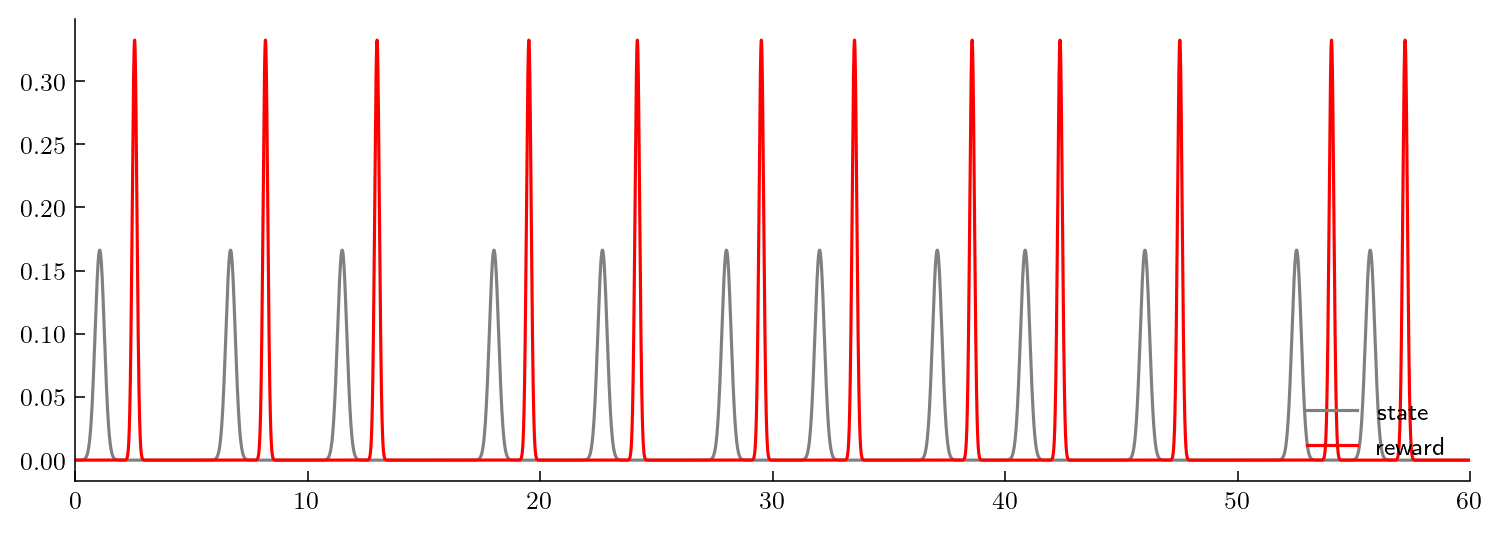

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
from rl.networks import ValueCritic, LMUProcess, LMUNetwork
from rl.utils import sparsity_to_x_intercept
from scipy.special import legendre


T=60
dt = 0.001
timesteps = np.arange(0,T,dt)
d_trial = 5
d_delay = 1.5

n_trials = int(T/d_trial)

rew_o = 0.1
state_o = 0.2

state_centers = np.random.rand(n_trials)*(d_trial - state_o - rew_o*2 - d_delay) + state_o
state_centers = state_centers + d_trial*np.arange(n_trials)
def sim_fun(t):
    gausses = [(state_o*np.sqrt(2*np.pi))**(-1)*np.exp(-((t-c)/state_o)**2/2) for c in state_centers]
    return np.sum(np.array(gausses),axis=0)/len(state_centers)

sim_path = sim_fun(timesteps)

rew_centers = state_centers + d_delay
def reward_fun(t):
    gausses = [(rew_o*np.sqrt(2*np.pi))**(-1)*np.exp(-((t-c)/rew_o)**2/2) for c in rew_centers]
    return np.sum(np.array(gausses),axis=0)/len(rew_centers)

rewards = reward_fun(timesteps)
    
plt.figure(figsize=(9,3))

plt.plot(timesteps,sim_path, label='state',color='grey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')


In [2]:
def run(
    T,
    n_neurons_state=100,
    n_neurons_value=400,
    n_neurons_lmu=800,
    discount = 0.95,
    theta = 5,
    state_theta= 1.5, 
    q_a = 8,
    q_r = 8,
    q_v = 8,
    q_s = 8,
    LR = 2e-4,
    dt=0.001,
    rule='TDLambda',
    reward_synapse='none',  # 'alpha', 'deriv-alpha'
):
    if reward_synapse=='lowpass':
        syn = nengo.Lowpass(0.05)
    elif reward_synapse=='alpha':
        syn = nengo.Alpha(0.05)
    elif reward_synapse=='deriv-alpha':
        syn = nengo.LinearFilter([1, 0], [1]).combine(nengo.Alpha(0.2))
    else:
        syn = None


    model = nengo.Network(seed=0)
    with model:
        state = nengo.Node(sim_fun)
        reward = nengo.Node(reward_fun)

        state_lmu_ensemble = LMUNetwork(n_neurons_lmu, theta=state_theta, q=q_s, size_in=1, tau=0.1, 
                                        radius=0.5,  intercepts=nengo.dists.Uniform(-0.1,0.4))
        nengo.Connection(state, state_lmu_ensemble.input, synapse=0.01)
        
        VL = ValueCritic(n_neurons_lmu, n_neurons_value, theta, q_s, 
                         discount, q_a, q_r, q_v, rule,
                         T_test=0.8*T,learning_rate=LR,
                        state_ensembles=[state_lmu_ensemble.lmu.ea_ensembles[0]]) # this works because the state is 1D, if it was higher I'd have to regroup all neurons
        
        nengo.Connection(reward, VL.reward_input, synapse=syn)
        
        V_p = nengo.Probe(VL.value, synapse=0.05)
        # Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
        # r_p = nengo.Probe(reward, synapse=syn)
        # rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
        # stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
        # stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
        # er_p = nengo.Probe(VL.rule, "error", synapse=None)
        
    
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(T)
    ts = sim.trange() 

    return ts, sim.data[V_p]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

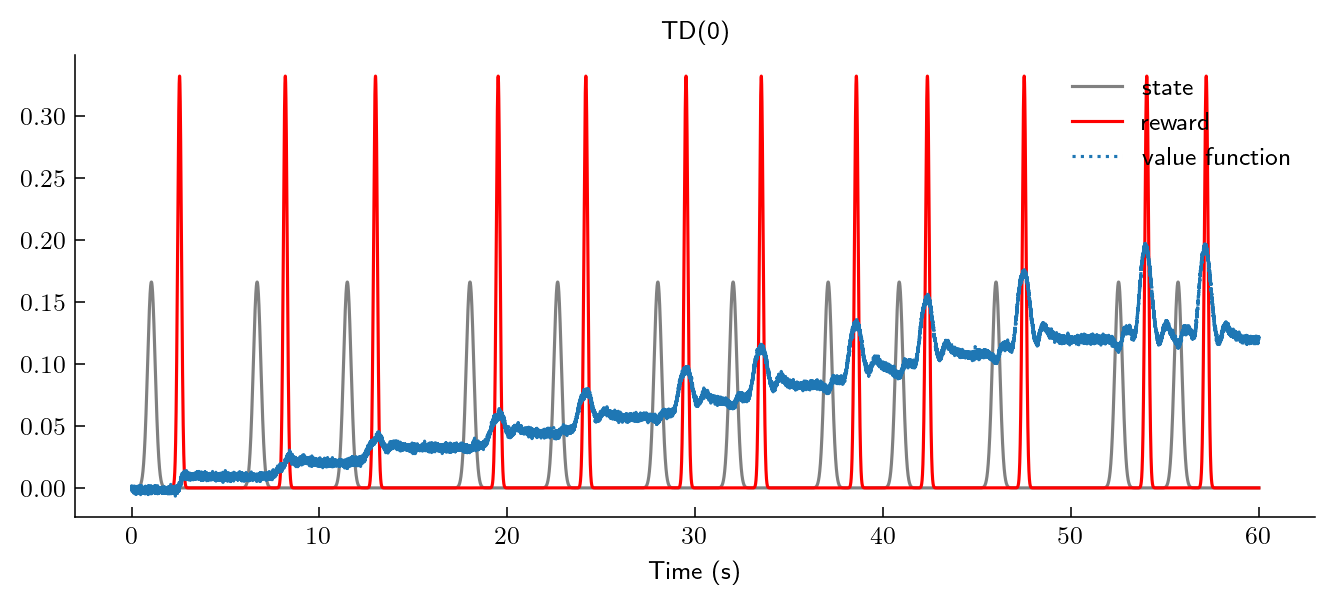

In [3]:
ts, td0_output = run(T, theta=0.01, rule='TD0')
plt.figure(figsize=(8,3))
plt.plot(timesteps,sim_path, label='state',color='gray')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(ts, td0_output, ':', label='value function')
plt.legend()
plt.title('TD(0)')
plt.xlabel('Time (s)')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

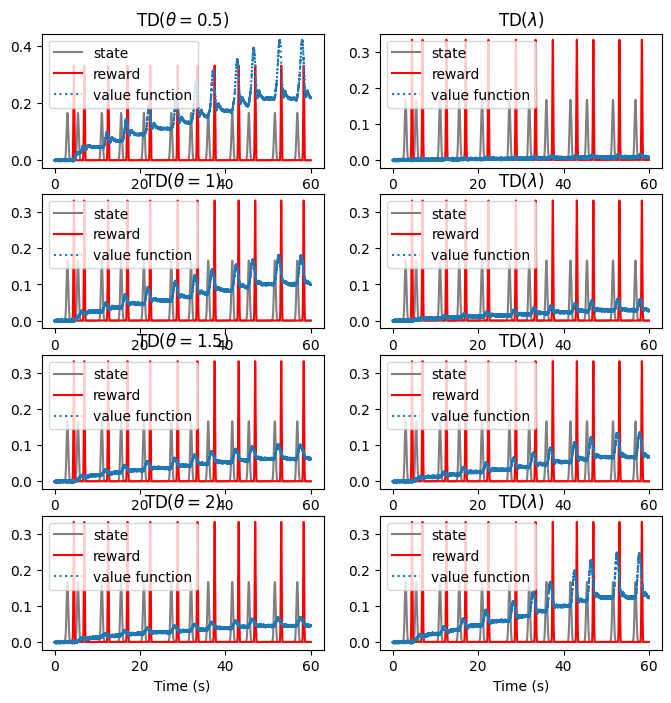

In [4]:
thetas = [0.5,1,1.5,2]
tdtheta_outputs = np.zeros((len(thetas), td0_output.shape[0], td0_output.shape[1]))
tdlbds_outputs = np.zeros((len(thetas), td0_output.shape[0], td0_output.shape[1]))

fig,axs=plt.subplots(len(thetas), 2, figsize=(8,2*len(thetas)))
for j,theta in enumerate(thetas):
    ts, tdtheta_output = run(T, theta=theta, rule='TDtheta')
    tdtheta_outputs[j,:,:] = tdtheta_output
    ts, tdlbd_output = run(T, theta=theta, rule='TDLambda',LR=1e-4)
    tdlbds_outputs[j,:,:] = tdlbd_output
    
    axs[j,0].plot(timesteps,sim_path, label='state',color='gray')
    axs[j,0].plot(timesteps,rewards, label='reward', color='red')
    axs[j,0].plot(ts, tdtheta_output, ':', label='value function')
    axs[j,0].legend()
    axs[j,0].set_title(f'TD($\\theta=${theta})')
    if j==len(thetas)-1:
        axs[j,0].set_xlabel('Time (s)')

    axs[j,1].plot(timesteps,sim_path, label='state',color='gray')
    axs[j,1].plot(timesteps,rewards, label='reward', color='red')
    axs[j,1].plot(ts, tdlbd_output, ':', label='value function')
    axs[j,1].legend()
    axs[j,1].set_title(f'TD($\\lambda$)')
    if j==len(thetas)-1:
        axs[j,1].set_xlabel('Time (s)')

Text(0, 0.5, 'Value')

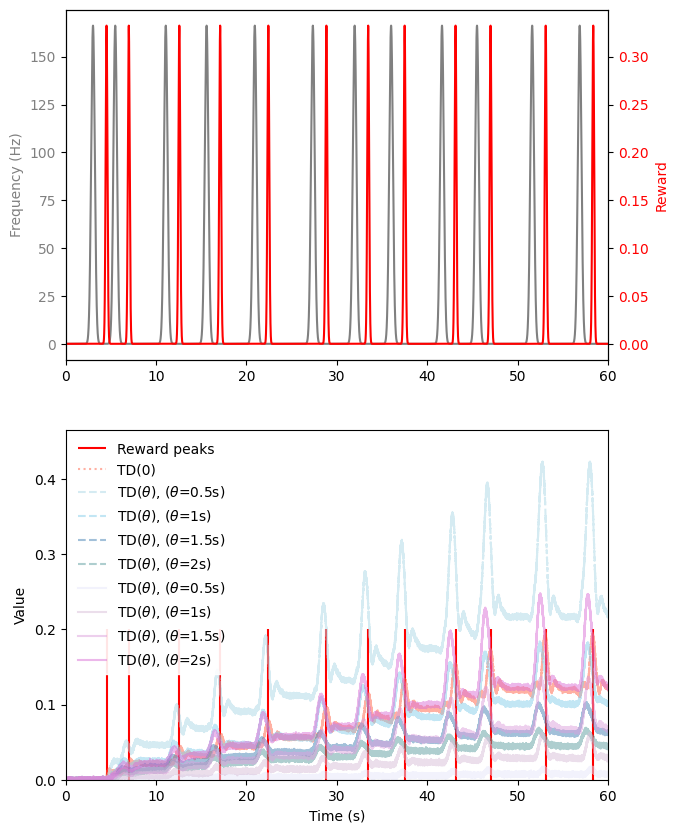

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(7,10))

ax1 = axs[0]
color = 'gray'
ax1.set_ylabel('Frequency (Hz)', color=color)
ax1.plot(timesteps, sim_path*1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([0,T])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Reward', color=color)  # we already handled the x-label with ax1
ax2.plot(timesteps, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.spines['right'].set_visible(True)
axs[1].vlines(rew_centers, 0,0.2, color=color,label='Reward peaks',alpha=1)

blues = ['#ADD8E6', '#87CEEB', '#4682B4', '#5F9EA0', '#1E90FF', '#4169E1', '#0000FF', '#00008B']
oranges = ['#FFA07A', '#FF7F50', '#FF6347', '#FF4500', '#FF8C00', '#FF7500', '#FF6600', '#FF4500']
purples = ['#E6E6FA', '#D8BFD8', '#DDA0DD', '#DA70D6', '#BA55D3', '#9370DB', '#8A2BE2', '#800080']


axs[1].plot(ts, td0_output, ':', label='TD(0)',alpha=0.5, color=oranges[2])
for i,theta in enumerate(thetas):
    axs[1].plot(ts, tdtheta_outputs[i], '--', color=blues[i], label='TD($\\theta$), ($\\theta$=' + str(theta) + 's)',alpha=0.5)
for i,theta in enumerate(thetas):
    axs[1].plot(ts, tdlbds_outputs[i], '-', color=purples[i], label='TD($\\theta$), ($\\theta$=' + str(theta) + 's)',alpha=0.5)

axs[1].legend(frameon=True,edgecolor='white',framealpha=0.9)
axs[1].set_xlim([0,T])
axs[1].set_ylim([0,np.max(tdtheta_outputs)*1.1])

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Value')